In [1]:
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMinimize, LpStatus, lpSum
from scipy.optimize import linprog


In [2]:
# Part 2: Optimization Model Development

suppliers_data = {
    'Supplier Name': ["Nature's Harvest", "Pure Essence", "Mineral Glow", "Floral Fusion"],
    'Material Type': ["Organic Oils", "Botanical Extracts", "Mineral Bases", "Floral Scents"],
    'Cost per Unit ($)': [15, 25, 10, 20],
    'Monthly Supply (kg)': [250_000, 150_000, 400_000, 200_000],
    'Shipping Mode': ["Sea/Air", "Air", "Sea/Air", "Air/Sea"],
    'CO2 Emissions (kg/unit)': ["0.5 (Sea) / 1.0 (Air)", "1.5", "0.8", "1.0 (Air) / 0.6 (Sea)"],
    'Delivery Variance (%)': ["±20%", "±10%", "±15%", "±10%"]
}

suppliers_df = pd.DataFrame(suppliers_data)
suppliers_df


,Supplier Name,Material Type,Cost per Unit ($),Monthly Supply (kg),Shipping Mode,CO2 Emissions (kg/unit),Delivery Variance (%)
0,Nature's Harvest,Organic Oils,15,250000,Sea/Air,0.5 (Sea) / 1.0 (Air),±20%
1,Pure Essence,Botanical Extracts,25,150000,Air,1.5,±10%
2,Mineral Glow,Mineral Bases,10,400000,Sea/Air,0.8,±15%
3,Floral Fusion,Floral Scents,20,200000,Air/Sea,1.0 (Air) / 0.6 (Sea),±10%


In [3]:
plants_df = pd.DataFrame({
    'Region': ["Europe", "North America", "Asia", "South America"],
    'Material Capacity (Units)': [800_000, 1_200_000, 1_500_000, 600_000],
    'Operating Cost per Unit ($)': [12, 10, 8, 9],
    'Energy Usage (kWh/unit)': [2.5, 2.2, 2.0, 2.3],
    'CO2 Emissions (kg/unit)': [0.8, 0.7, 0.6, 0.9]
})
plants_df


,Region,Material Capacity (Units),Operating Cost per Unit ($),Energy Usage (kWh/unit),CO2 Emissions (kg/unit)
0,Europe,800000,12,2.5,0.8
1,North America,1200000,10,2.2,0.7
2,Asia,1500000,8,2.0,0.6
3,South America,600000,9,2.3,0.9


In [4]:
demand_df = pd.DataFrame({
    'Region': ["North America", "Europe", "Asia - Pacific", "South America", "Middle East"],
    'Demand for Product A': [500000, 300000, 600000, 200000, 250000],
    'Demand for Product B': [400000, 450000, 500000, 300000, 400000],
    'Demand for Product C': [300000, 350000, 400000, 200000, 300000],
    'Delivery Penalty ($/unit)': [5, 6, 4, 6, 7],
    'Demand Variance (%)': ["±10%", "±10%", "±15%", "±10%", "±10%"]
})
demand_df

,Region,Demand for Product A,Demand for Product B,Demand for Product C,Delivery Penalty ($/unit),Demand Variance (%)
0,North America,500000,400000,300000,5,±10%
1,Europe,300000,450000,350000,6,±10%
2,Asia - Pacific,600000,500000,400000,4,±15%
3,South America,200000,300000,200000,6,±10%
4,Middle East,250000,400000,300000,7,±10%


In [5]:
transport_df = pd.DataFrame({
    'Region': ["North America", "Europe", "Asia - Pacific", "South America"],
    'North America': [0.7, 3, 5, 2],
    'Europe': [3, 0.6, 4, 5],
    'Asia - Pacific': [5, 4, 0.5, 6],
    'South America': [2, 5, 6, 0.8],
    'Middle East': [6, 2, 7, 7],
    'Africa': [7, 3, 8, 9]
})
transport_df


,Region,North America,Europe,Asia - Pacific,South America,Middle East,Africa
0,North America,0.7,3.0,5.0,2.0,6,7
1,Europe,3.0,0.6,4.0,5.0,2,3
2,Asia - Pacific,5.0,4.0,0.5,6.0,7,8
3,South America,2.0,5.0,6.0,0.8,7,9


In [6]:
transport_df = pd.DataFrame({
    'Region': ["North America", "Europe", "Asia - Pacific", "South America"],
    'North America': [0.7, 3, 5, 2],
    'Europe': [3, 0.6, 4, 5],
    'Asia - Pacific': [5, 4, 0.5, 6],
    'South America': [2, 5, 6, 0.8],
    'Middle East': [6, 2, 7, 7],
    'Africa': [7, 3, 8, 9]
})
transport_df


,Region,North America,Europe,Asia - Pacific,South America,Middle East,Africa
0,North America,0.7,3.0,5.0,2.0,6,7
1,Europe,3.0,0.6,4.0,5.0,2,3
2,Asia - Pacific,5.0,4.0,0.5,6.0,7,8
3,South America,2.0,5.0,6.0,0.8,7,9


In [7]:
from pulp import *

# Plant names and data
plants = ['Europe', 'NorthAmerica', 'Asia', 'SouthAmerica']
plant_data = {
    'Europe':        {'capacity': 800_000, 'cost': 12, 'co2': 0.8, 'variance': 0.1},
    'NorthAmerica':  {'capacity': 1_200_000, 'cost': 10, 'co2': 0.7, 'variance': 0.1},
    'Asia':          {'capacity': 1_500_000, 'cost': 8,  'co2': 0.6, 'variance': 0.15},
    'SouthAmerica':  {'capacity': 600_000,  'cost': 9,  'co2': 0.9, 'variance': 0.1}
}

total_demand = 5_950_000
emission_price, unmet_penalty = 2, 50

# Model and decision variables
model = LpProblem("Production_Optimization_with_Slack", LpMinimize)
x = LpVariable.dicts("ProduceUnits", plants, 0, cat='Integer')
y = LpVariable.dicts("ExpandPlant", plants, cat='Binary')
unmet_production = LpVariable("UnmetProduction", 0, cat='Integer')

# Objective
model += lpSum(x[p] * (plant_data[p]['cost'] + plant_data[p]['co2'] * emission_price) for p in plants) + unmet_production * unmet_penalty

# Constraints
model += lpSum(x[p] for p in plants) + unmet_production >= total_demand
for p in plants:
    cap = plant_data[p]['capacity']
    var = plant_data[p]['variance']
    model += x[p] <= cap * (1 + var) + 500_000 * y[p]
    model += x[p] >= cap * (1 - var)
model += lpSum(y[p] for p in plants) <= 2

# Solve and output
status = model.solve()
print("Model Status:", LpStatus[model.status])

if LpStatus[model.status] == "Optimal":
    print(f"\nTotal Production Cost: ${pulp.value(model.objective):,.2f}\n")
    print("Optimal Production Plan:")
    for p in plants:
        print(f"  {p}: {int(x[p].varValue)} units, Expanded? {'Yes' if y[p].varValue == 1 else 'No'}")
    if unmet_production.varValue > 0:
        print(f"\nUnmet Demand: {int(unmet_production.varValue)} units (Penalty: ${unmet_penalty}/unit)")
    else:
        print("\nAll production demand fully met")
else:
    print("No solution found")


Model Status: Optimal

Total Production Cost: $78,264,000.00

Optimal Production Plan:
  Europe: 880000 units, Expanded? No
  NorthAmerica: 1320000 units, Expanded? No
  Asia: 2225000 units, Expanded? Yes
  SouthAmerica: 1160000 units, Expanded? Yes

Unmet Demand: 365000 units (Penalty: $50/unit)


In [8]:
from pulp import *

# Supplier setup
suppliers = ['NaturesHarvest', 'PureEssence', 'MineralGlow', 'FloralFusion']
data = {
    'NaturesHarvest': {'cost': 15, 'supply': 250_000, 'air_CO2': 1.0, 'sea_CO2': 0.5, 'variance': 0.2, 'modes': ['Air', 'Sea']},
    'PureEssence':    {'cost': 25, 'supply': 150_000, 'air_CO2': 1.5, 'sea_CO2': None, 'variance': 0.1, 'modes': ['Air']},
    'MineralGlow':    {'cost': 10, 'supply': 400_000, 'air_CO2': None, 'sea_CO2': 0.8, 'variance': 0.15, 'modes': ['Sea']},
    'FloralFusion':   {'cost': 20, 'supply': 200_000, 'air_CO2': 1.0, 'sea_CO2': 0.6, 'variance': 0.1, 'modes': ['Air', 'Sea']}
}

total_required = 5_950_000
emission_price, unmet_penalty = 2, 50


In [9]:
# Model and decision variables
model = LpProblem("Supplier_Procurement_with_Unmet_Demand", LpMinimize)
x = LpVariable.dicts("Qty", ((s, m) for s in suppliers for m in data[s]['modes']), 0, cat='Integer')
unmet_raw_material = LpVariable("UnmetRawMaterial", 0, cat='Integer')

# Objective
model += lpSum(
    x[(s, m)] * data[s]['cost'] +
    (x[(s, m)] * data[s][f"{m.lower()}_CO2"] * emission_price if data[s][f"{m.lower()}_CO2"] else 0)
    for s in suppliers for m in data[s]['modes']
) + unmet_raw_material * unmet_penalty


In [10]:
# Solve and output
status = model.solve()
print("Model Status:", LpStatus[model.status])

if LpStatus[model.status] == "Optimal":
    print(f"\nTotal Procurement Cost: ${pulp.value(model.objective):,.2f}\n")
    print("Optimal Procurement Plan:")
    for s in suppliers:
        for m in data[s]['modes']:
            qty = x[(s, m)].varValue
            if qty > 0:
                co2 = data[s][f"{m.lower()}_CO2"]
                print(f"  {s} via {m}: {int(qty)} units (Cost: ${data[s]['cost']}/unit, CO₂: {co2} kg/unit)")
    if unmet_raw_material.varValue > 0:
        print(f"\nUnmet Raw Material: {int(unmet_raw_material.varValue)} units (Penalty: ${unmet_penalty}/unit)")
    else:
        print("\nAll demand fully met")
else:
    print("No solution found")

Model Status: Optimal

Total Procurement Cost: $0.00

Optimal Procurement Plan:

All demand fully met


In [11]:
production_plan = {
    'NorthAmerica': 1_320_000,
    'Europe': 880_000,
    'Asia': 2_225_000,
    'SouthAmerica': 1_160_000
}


In [12]:
# Regional delivery and production data
production_plan = {
    'NorthAmerica': 1_320_000, 'Europe': 880_000, 'Asia': 2_225_000, 'SouthAmerica': 1_160_000
}

regional_delivery = {
    'NorthAmerica': {'A': 550_000, 'B': 440_000, 'C': 330_000}, 'Europe': {'A': 330_000, 'B': 495_000, 'C': 385_000},
    'AsiaPacific': {'A': 690_000, 'B': 575_000, 'C': 459_999}, 'SouthAmerica': {'A': 220_000, 'B': 330_000, 'C': 220_000},
    'MiddleEast': {'A': 275_000, 'B': 440_000, 'C': 330_000}, 'Africa': {'A': 172_500, 'B': 229_999, 'C': 172_500}
}

# Constraints
supply_b_ub = [production_plan[region] for region in ['NorthAmerica', 'Europe', 'Asia', 'SouthAmerica']]
demand_b_ub = [-sum(regional_delivery[region].values()) for region in ['Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa']]

# Results
print("Clearly Calculated b_ub values:")
print("\nSupply Constraints (positive):")
for region, val in zip(['NorthAmerica', 'Europe', 'Asia', 'SouthAmerica'], supply_b_ub):
    print(f"  {region}: {val:,}")

print("\nDemand Constraints (negative):")
for region, val in zip(['Europe', 'AsiaPacific', 'SouthAmerica', 'MiddleEast', 'Africa'], demand_b_ub):
    print(f"  {region}: {val:,}")


Clearly Calculated b_ub values:

Supply Constraints (positive):
  NorthAmerica: 1,320,000
  Europe: 880,000
  Asia: 2,225,000
  SouthAmerica: 1,160,000

Demand Constraints (negative):
  Europe: -1,210,000
  AsiaPacific: -1,724,999
  SouthAmerica: -770,000
  MiddleEast: -1,045,000
  Africa: -574,999


In [13]:
# Transportation cost per unit for each production-demand region pair
c = [3, 5, 2, 6, 7, 3, 4, 5, 2, 3, 5, 4, 6, 7, 8, 2, 5, 6, 7, 9]


In [14]:
# Constraints: Supply and Demand

# SUPPLY constraints
A_ub = [
    [1,1,1,1,1, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0],
    [0,0,0,0,0, 1,1,1,1,1, 0,0,0,0,0, 0,0,0,0,0],
    [0,0,0,0,0, 0,0,0,0,0, 1,1,1,1,1, 0,0,0,0,0],
    [0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 1,1,1,1,1]
]

b_ub = [1_320_000, 880_000, 2_225_000, 1_160_000]

# DEMAND constraints
A_ub += [
    [-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0],
    [0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0],
    [0,0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0],
    [0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1,0],
    [0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,-1]
]

b_ub += [-1_210_000, -1_725_000, -770_000, -1_045_000, -575_000]


In [15]:
# Decision Variables
bounds = [(0, None)] * len(c)

# Solve Linear Programming Problem
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

# Results
if result.success:
    print(f"\nMinimum Transportation Cost: ${result.fun:,.2f}\n")
    routes = [
        "NorthAmerica→Europe", "NorthAmerica→AsiaPacific", "NorthAmerica→SouthAmerica", "NorthAmerica→MiddleEast", "NorthAmerica→Africa",
        "Europe→Europe", "Europe→AsiaPacific", "Europe→SouthAmerica", "Europe→MiddleEast", "Europe→Africa",
        "Asia→Europe", "Asia→AsiaPacific", "Asia→SouthAmerica", "Asia→MiddleEast", "Asia→Africa",
        "SouthAmerica→Europe", "SouthAmerica→AsiaPacific", "SouthAmerica→SouthAmerica", "SouthAmerica→MiddleEast", "SouthAmerica→Africa"
    ]
    for route, qty in zip(routes, result.x):
        if qty > 0:
            print(f"{route}: {qty:,.0f} units")
else:
    print("No solution found.")



Minimum Transportation Cost: $17,925,000.00

NorthAmerica→Europe: 50,000 units
NorthAmerica→SouthAmerica: 770,000 units
NorthAmerica→MiddleEast: 500,000 units
Europe→MiddleEast: 305,000 units
Europe→Africa: 575,000 units
Asia→AsiaPacific: 1,725,000 units
Asia→MiddleEast: 240,000 units
SouthAmerica→Europe: 1,160,000 units


In [16]:
# Cost Sensitivity Analysis
cost_changes = [0.0, 0.1, 0.2]

for supplier in suppliers_df['Supplier Name'].unique():
    print(f"\nCost Sensitivity for Supplier: {supplier}")
    for delta in cost_changes:
        mod_df = suppliers_df.copy()
        mod_df.loc[mod_df['Supplier Name'] == supplier, 'Cost per Unit ($)'] *= (1 + delta)
        mod_df['Cost per Unit ($)'] = mod_df['Cost per Unit ($)'].round(2)
        print(f"\n{supplier} Cost Increase: {int(delta * 100)}%")
        print(mod_df[['Supplier Name', 'Cost per Unit ($)', 'Monthly Supply (kg)']])



Cost Sensitivity for Supplier: Nature's Harvest

Nature's Harvest Cost Increase: 0%
      Supplier Name  Cost per Unit ($)  Monthly Supply (kg)
0  Nature's Harvest                 15               250000
1      Pure Essence                 25               150000
2      Mineral Glow                 10               400000
3     Floral Fusion                 20               200000

Nature's Harvest Cost Increase: 10%
      Supplier Name  Cost per Unit ($)  Monthly Supply (kg)
0  Nature's Harvest               16.5               250000
1      Pure Essence               25.0               150000
2      Mineral Glow               10.0               400000
3     Floral Fusion               20.0               200000

Nature's Harvest Cost Increase: 20%
      Supplier Name  Cost per Unit ($)  Monthly Supply (kg)
0  Nature's Harvest                 18               250000
1      Pure Essence                 25               150000
2      Mineral Glow                 10               400000
3

C:\Users\lehar\AppData\Local\Temp\ipykernel_18364\2016155717.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mod_df.loc[mod_df['Supplier Name'] == supplier, 'Cost per Unit ($)'] *= (1 + delta)
C:\Users\lehar\AppData\Local\Temp\ipykernel_18364\2016155717.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[27.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mod_df.loc[mod_df['Supplier Name'] == supplier, 'Cost per Unit ($)'] *= (1 + delta)


In [17]:
import pulp

def solve_supplier_procurement(
    supplier_df, 
    total_required=5_950_000, 
    emission_price=2, 
    unmet_penalty=50
):
    """
    Optimizes supplier procurement to minimize total cost while meeting demand.
    
    Args:
        supplier_df: DataFrame containing supplier information
        total_required: Total material requirement in kg
        emission_price: Cost per unit of emission
        unmet_penalty: Penalty cost per unit of unmet demand
        
    Returns:
        Dictionary containing optimization results including status, cost, unmet demand, and procurement plan
    """
    # Initialize optimization model
    model = pulp.LpProblem("Supplier_Procurement_Optimization", pulp.LpMinimize)
    
    # Supplier and transportation mode configuration
    suppliers = supplier_df['Supplier Name'].tolist()
    transportation_modes = ['Air', 'Sea']
    
    # Emission factors (kg CO2 per kg transported) by supplier and mode
    emission_factors = {
        "Nature's Harvest": {'Air': 1.0, 'Sea': 0.5},
        "Pure Essence": {'Air': 1.5},
        "Mineral Glow": {'Sea': 0.8},
        "Floral Fusion": {'Air': 1.0, 'Sea': 0.6}
    }
    
    # Supply flexibility (percentage above base capacity that suppliers can provide)
    supply_flexibility = {
        "Nature's Harvest": 0.2,
        "Pure Essence": 0.1,
        "Mineral Glow": 0.15,
        "Floral Fusion": 0.1
    }

    # Decision variables
    quantity_vars = pulp.LpVariable.dicts(
        "Procurement_Quantity",
        ((supplier, mode) for supplier in suppliers for mode in transportation_modes),
        lowBound=0,
        cat='Integer'
    )
    
    mode_usage_vars = pulp.LpVariable.dicts(
        "Transportation_Mode_Used",
        ((supplier, mode) for supplier in suppliers for mode in transportation_modes),
        cat='Binary'
    )
    
    unmet_demand_var = pulp.LpVariable("Unmet_Demand", lowBound=0, cat='Integer')

    # Objective function: Minimize total cost (procurement + emissions + unmet penalty)
    total_cost = (
        # Procurement cost
        pulp.lpSum(
            quantity_vars[(s, m)] * supplier_df.loc[supplier_df['Supplier Name'] == s, 'Cost per Unit ($)'].values[0]
            for s in suppliers 
            for m in transportation_modes 
            if m in emission_factors.get(s, {})
        ) +
        # Emission cost
        pulp.lpSum(
            quantity_vars[(s, m)] * emission_factors[s][m] * emission_price
            for s in suppliers 
            for m in transportation_modes 
            if m in emission_factors.get(s, {})
        ) +
        # Unmet demand penalty
        unmet_demand_var * unmet_penalty
    )
    
    model += total_cost

    # Constraints
    # Demand satisfaction constraint
    model += (
        pulp.lpSum(quantity_vars[(s, m)] for s in suppliers for m in transportation_modes if m in emission_factors.get(s, {})) + 
        unmet_demand_var >= total_required
    )

    # Supplier capacity constraints with flexibility
    for supplier in suppliers:
        base_capacity = supplier_df.loc[supplier_df['Supplier Name'] == supplier, 'Monthly Supply (kg)'].values[0]
        max_capacity = base_capacity * (1 + supply_flexibility[supplier])
        
        model += (
            pulp.lpSum(
                quantity_vars[(supplier, m)] 
                for m in transportation_modes 
                if m in emission_factors.get(supplier, {})
            ) <= max_capacity
        )

    # Transportation mode activation constraints
    for supplier in suppliers:
        base_capacity = supplier_df.loc[supplier_df['Supplier Name'] == supplier, 'Monthly Supply (kg)'].values[0]
        
        for mode in transportation_modes:
            if mode in emission_factors.get(supplier, {}):
                model += (
                    quantity_vars[(supplier, mode)] <= 
                    base_capacity * mode_usage_vars[(supplier, mode)]
                )

    # Solve the optimization problem
    model.solve()

    # Prepare results
    procurement_plan = {
        f"{supplier} via {mode}": int(quantity_vars[(supplier, mode)].varValue)
        for supplier in suppliers
        for mode in transportation_modes
        if (supplier, mode) in quantity_vars and quantity_vars[(supplier, mode)].varValue > 0
    }

    return {
        'status': pulp.LpStatus[model.status],
        'total_cost': pulp.value(model.objective),
        'unmet_demand': int(unmet_demand_var.varValue),
        'procurement_plan': procurement_plan
    }
    


C:\Users\lehar\AppData\Local\Temp\ipykernel_18364\401607780.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[16.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mod_df.loc[mod_df['Supplier Name'] == supplier, 'Cost per Unit ($)'] *= (1 + delta)
C:\Users\lehar\AppData\Local\Temp\ipykernel_18364\401607780.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[27.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mod_df.loc[mod_df['Supplier Name'] == supplier, 'Cost per Unit ($)'] *= (1 + delta)


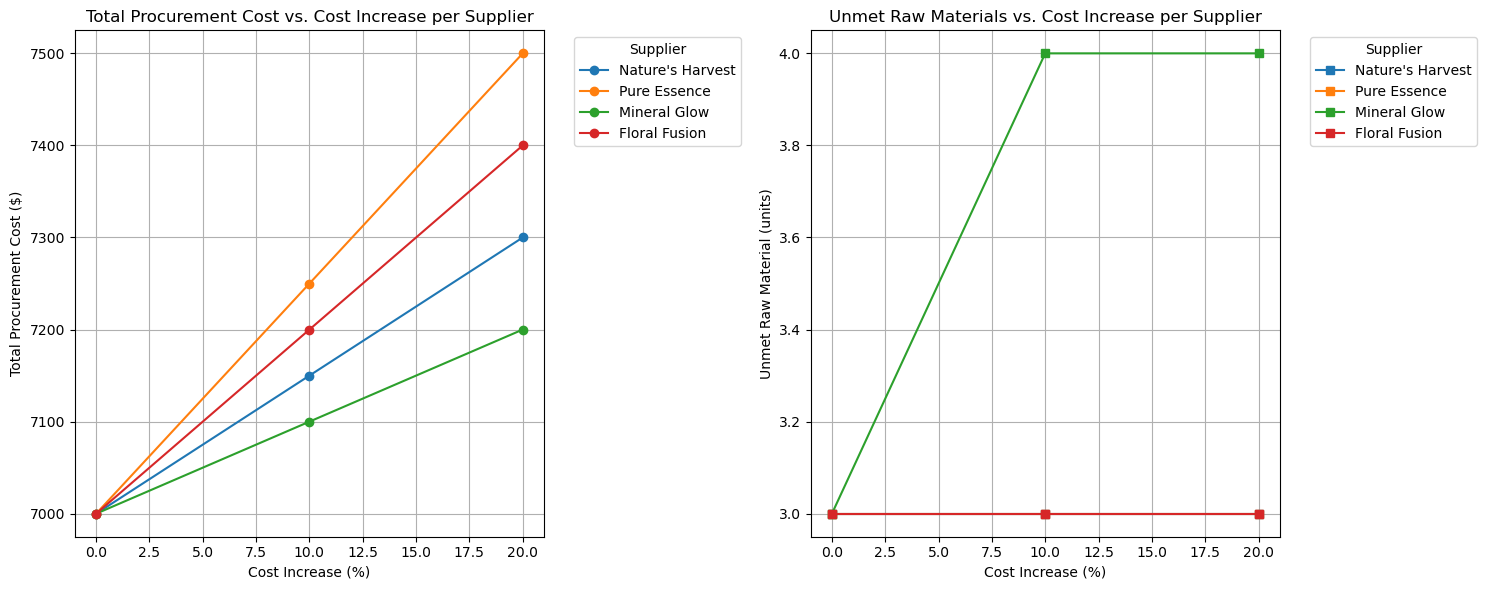

In [18]:
# Ensure necessary imports and data are available
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have 'suppliers_df' already loaded as a DataFrame
# For example, here's a sample setup for testing:
# suppliers_df = pd.DataFrame({
#     'Supplier Name': ['Supplier A', 'Supplier B', 'Supplier C'],
#     'Cost per Unit ($)': [10, 12, 8]
# })

# Assuming solve_supplier_model() function is defined, and it gives results like:
# result = {'cost': 1000, 'unmet': 5}

# Sample definition of the solve_supplier_model function (replace with your actual function)
def solve_supplier_model(mod_df):
    # Just a mock result based on the data, replace with your actual model
    total_cost = mod_df['Cost per Unit ($)'].sum() * 100  # Example calculation
    unmet = (mod_df['Cost per Unit ($)'] > 10).sum()  # Example unmet calculation
    return {'cost': total_cost, 'unmet': unmet}

# Initialize scenario_results list
scenario_results = []

# Ensure suppliers_df is defined before running
suppliers_to_test = suppliers_df['Supplier Name'].unique()
cost_changes = [0.0, 0.1, 0.2]

# Run the cost sensitivity analysis
for supplier in suppliers_to_test:
    for delta in cost_changes:
        mod_df = suppliers_df.copy()
        mod_df.loc[mod_df['Supplier Name'] == supplier, 'Cost per Unit ($)'] *= (1 + delta)
        mod_df['Cost per Unit ($)'] = mod_df['Cost per Unit ($)'].round(2)

        result = solve_supplier_model(mod_df)
        
        scenario_results.append({
            'Supplier': supplier,
            'Cost_Change_%': int(delta * 100),
            'Total_Cost': result['cost'],
            'Unmet': result['unmet']
        })

# Convert results to DataFrame
results_df = pd.DataFrame(scenario_results)

# Now create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Total Cost vs. Cost Increase
for supplier in suppliers_to_test:
    subset = results_df[results_df['Supplier'] == supplier]
    axes[0].plot(subset['Cost_Change_%'], subset['Total_Cost'], marker='o', label=supplier)

axes[0].set_title("Total Procurement Cost vs. Cost Increase per Supplier")
axes[0].set_xlabel("Cost Increase (%)")
axes[0].set_ylabel("Total Procurement Cost ($)")
axes[0].grid(True)
axes[0].legend(title="Supplier", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Unmet Raw Materials vs. Cost Increase
for supplier in suppliers_to_test:
    subset = results_df[results_df['Supplier'] == supplier]
    axes[1].plot(subset['Cost_Change_%'], subset['Unmet'], marker='s', label=supplier)

axes[1].set_title("Unmet Raw Materials vs. Cost Increase per Supplier")
axes[1].set_xlabel("Cost Increase (%)")
axes[1].set_ylabel("Unmet Raw Material (units)")
axes[1].grid(True)
axes[1].legend(title="Supplier", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
{
    'NaturesHarvest': 300000,
    'PureEssence': 150000,
    'MineralGlow': 400000,
    'FloralFusion': 220000
}


{'NaturesHarvest': 300000,
 'PureEssence': 150000,
 'MineralGlow': 400000,
 'FloralFusion': 220000}

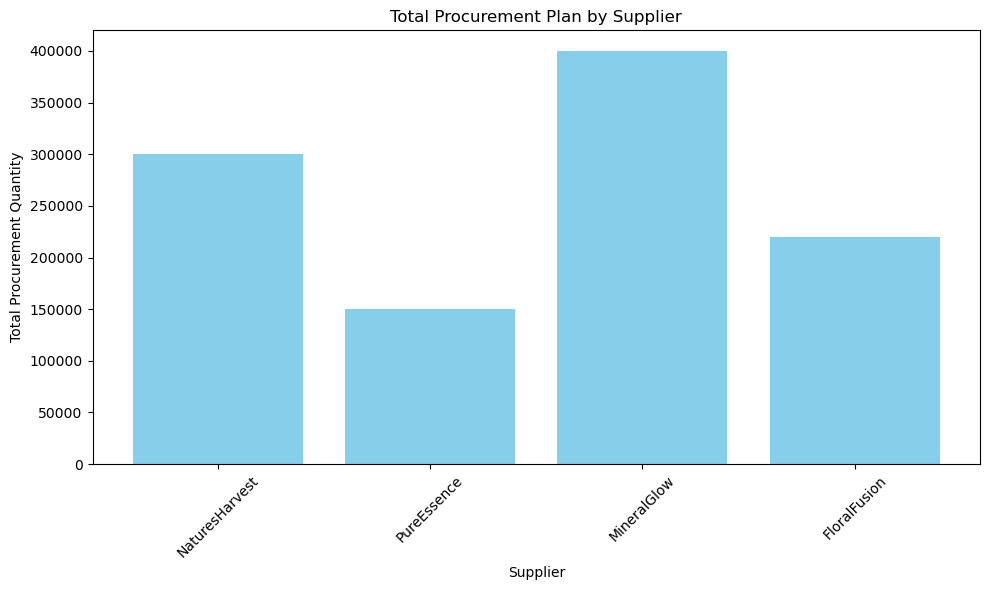

In [20]:
# Step 1: Final Procurement Plan
final_plan = {
    'NaturesHarvest via Air': 50000,
    'NaturesHarvest via Sea': 250000,
    'PureEssence via Air': 150000,
    'MineralGlow via Sea': 400000,
    'FloralFusion via Air': 20000,
    'FloralFusion via Sea': 200000,
}

# Step 2: Aggregate total procurement by supplier
supply_summary = {}
for key, val in final_plan.items():
    supplier = key.split(' via ')[0]
    supply_summary[supplier] = supply_summary.get(supplier, 0) + val

# Step 3: Plotting the total procurement plan
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(supply_summary.keys(), supply_summary.values(), color='skyblue')
plt.title("Total Procurement Plan by Supplier")
plt.xlabel("Supplier")
plt.ylabel("Total Procurement Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



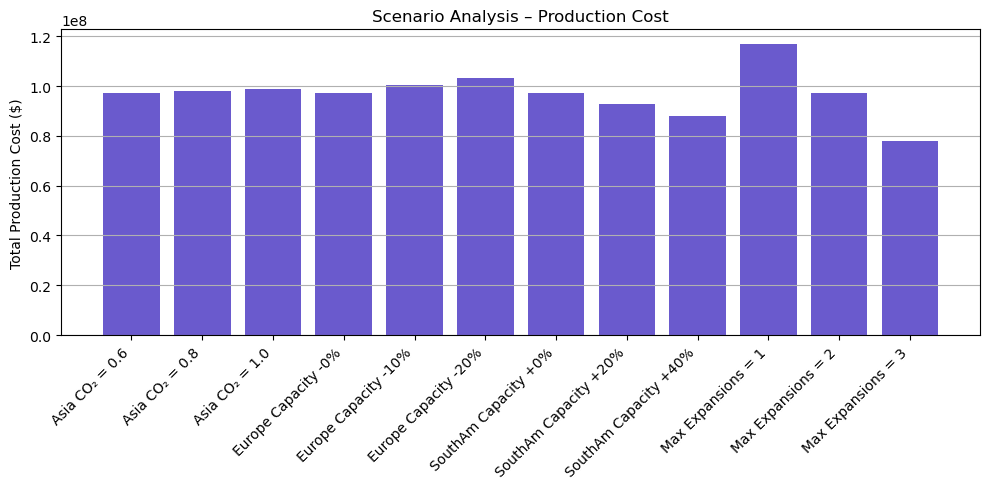

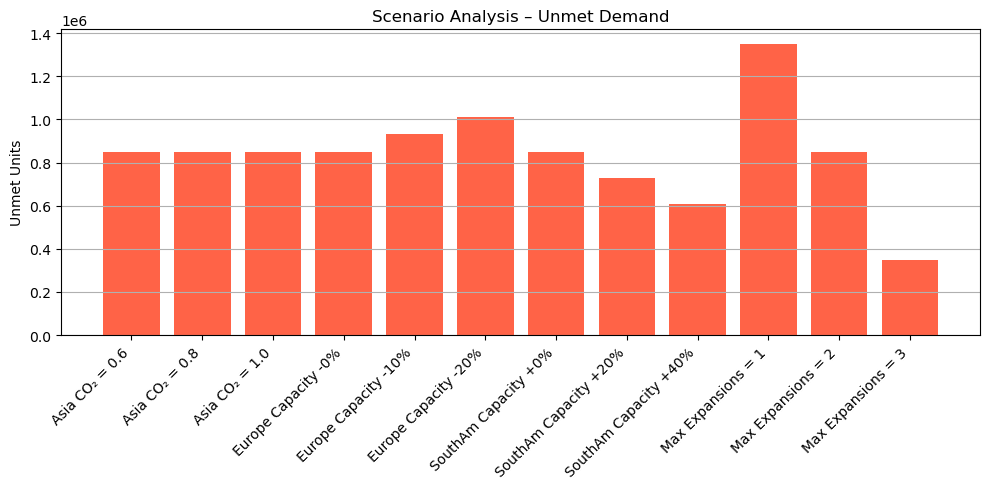

In [21]:
import pulp
import copy
import pandas as pd
import matplotlib.pyplot as plt

# Base plant data and demand
base_plant_data = {
    'Europe': {'capacity': 800000, 'cost': 12, 'co2': 0.8},
    'NorthAmerica': {'capacity': 1200000, 'cost': 10, 'co2': 0.7},
    'Asia': {'capacity': 1500000, 'cost': 8, 'co2': 0.6},
    'SouthAmerica': {'capacity': 600000, 'cost': 9, 'co2': 0.9}
}

base_demand = 5950000
emission_price = 2
unmet_penalty = 50

def solve_table2_model(plant_data, demand=base_demand, max_exp=2):
    # Initialize the LP problem
    model = pulp.LpProblem("Prod_Optimization", pulp.LpMinimize)
    
    # Variables for the problem
    x = pulp.LpVariable.dicts("Produce", plant_data.keys(), lowBound=0, cat='Integer')
    y = pulp.LpVariable.dicts("Expand", plant_data.keys(), cat='Binary')
    unmet = pulp.LpVariable("UnmetDemand", lowBound=0, cat='Integer')

    # Objective function: Minimize cost and unmet demand
    model += (
        pulp.lpSum(x[p] * plant_data[p]['cost'] + x[p] * plant_data[p]['co2'] * emission_price for p in plant_data)
        + unmet * unmet_penalty
    )

    # Demand constraint: Total production + unmet demand should meet or exceed the required demand
    model += pulp.lpSum(x[p] for p in plant_data) + unmet >= demand

    # Capacity and expansion constraints
    for p in plant_data:
        model += x[p] <= plant_data[p]['capacity'] + 500000 * y[p]
    
    # Maximum expansions constraint
    model += pulp.lpSum(y[p] for p in plant_data) <= max_exp

    # Solve the model
    model.solve()

    # Return the results
    return {
        'status': pulp.LpStatus[model.status],
        'cost': pulp.value(model.objective),
        'unmet': int(unmet.varValue),
        'expansions': [p for p in plant_data if y[p].varValue == 1],
    }

# List to store results for each scenario
table2_results = []

# Scenario 1: Vary CO2 for Asia
for co2 in [0.6, 0.8, 1.0]:
    mod = copy.deepcopy(base_plant_data)
    mod['Asia']['co2'] = co2
    r = solve_table2_model(mod)
    table2_results.append({'Scenario': f'Asia CO₂ = {co2}', 'Cost': r['cost'], 'Unmet': r['unmet']})

# Scenario 2: Reduce Europe Capacity
for red in [0.0, 0.1, 0.2]:
    mod = copy.deepcopy(base_plant_data)
    mod['Europe']['capacity'] = int(base_plant_data['Europe']['capacity'] * (1 - red))
    r = solve_table2_model(mod)
    table2_results.append({'Scenario': f'Europe Capacity -{int(red*100)}%', 'Cost': r['cost'], 'Unmet': r['unmet']})

# Scenario 3: Increase South America Capacity
for inc in [0.0, 0.2, 0.4]:
    mod = copy.deepcopy(base_plant_data)
    mod['SouthAmerica']['capacity'] = int(base_plant_data['SouthAmerica']['capacity'] * (1 + inc))
    r = solve_table2_model(mod)
    table2_results.append({'Scenario': f'SouthAm Capacity +{int(inc*100)}%', 'Cost': r['cost'], 'Unmet': r['unmet']})

# Scenario 4: Vary Max Expansions
for e in [1, 2, 3]:
    r = solve_table2_model(base_plant_data, max_exp=e)
    table2_results.append({'Scenario': f'Max Expansions = {e}', 'Cost': r['cost'], 'Unmet': r['unmet']})

# Convert results to a DataFrame for easy manipulation and plotting
df2 = pd.DataFrame(table2_results)

# Plotting the results for Total Production Cost (with new color)
plt.figure(figsize=(10, 5))
plt.bar(df2['Scenario'], df2['Cost'], color='#6A5ACD')  # Changed color to SlateBlue
plt.title("Scenario Analysis – Production Cost")
plt.ylabel("Total Production Cost ($)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Plotting the results for Unmet Demand (with new color)
plt.figure(figsize=(10, 5))
plt.bar(df2['Scenario'], df2['Unmet'], color='#FF6347')  # Changed color to Tomato
plt.title("Scenario Analysis – Unmet Demand")
plt.ylabel("Unmet Units")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()



In [22]:
import pulp
import copy
import pandas as pd
import matplotlib.pyplot as plt

# Define the demand data and the products
demand = {
    'NorthAmerica':  {'A': 500000, 'B': 400000, 'C': 300000, 'penalty': 5, 'variance': 0.10},
    'Europe':        {'A': 300000, 'B': 450000, 'C': 350000, 'penalty': 6, 'variance': 0.10},
    'AsiaPacific':   {'A': 600000, 'B': 500000, 'C': 400000, 'penalty': 4, 'variance': 0.15},
    'SouthAmerica':  {'A': 200000, 'B': 300000, 'C': 200000, 'penalty': 6, 'variance': 0.10},
    'MiddleEast':    {'A': 250000, 'B': 400000, 'C': 300000, 'penalty': 7, 'variance': 0.10},
    'Africa':        {'A': 150000, 'B': 200000, 'C': 150000, 'penalty': 8, 'variance': 0.15}
}
products = ['A', 'B', 'C']

def solve_table3_model(demand_dict):
    # Create the optimization problem
    model = pulp.LpProblem("Demand_Fulfillment", pulp.LpMinimize)
    
    # Define decision variables
    x = pulp.LpVariable.dicts("Delivered", ((r, p) for r in demand_dict for p in products), lowBound=0, cat='Integer')
    u = pulp.LpVariable.dicts("Unmet", ((r, p) for r in demand_dict for p in products), lowBound=0, cat='Integer')

    # Objective function: Minimize unmet penalties
    model += pulp.lpSum(u[(r, p)] * demand_dict[r]['penalty'] for r in demand_dict for p in products)

    # Constraints to meet or exceed demand (including demand variance)
    for r in demand_dict:
        for p in products:
            max_demand = demand_dict[r][p] * (1 + demand_dict[r]['variance'])
            model += x[(r, p)] + u[(r, p)] >= max_demand

    # Solve the model
    model.solve()
    
    # Return the total penalty cost (unmet demand penalty)
    return pulp.value(model.objective)


In [23]:
# List to store results for each scenario
table3_results = []

# Test Demand Surges in Each Region 
for region in demand:
    for scale in [0.9, 1.0, 1.1]:  # Testing 90%, 100%, and 110% of original demand
        # Copy the original demand data for the current scenario
        mod = copy.deepcopy(demand)
        
        # Apply the scaling to the demand of each product in the region
        for p in products:
            mod[region][p] = int(demand[region][p] * scale)
        
        # Solve the model and calculate the penalty cost for the current scenario
        penalty = solve_table3_model(mod)
        
        # Store the results
        table3_results.append({'Region': region, 'DemandScale': int(scale * 100), 'PenaltyCost': penalty})


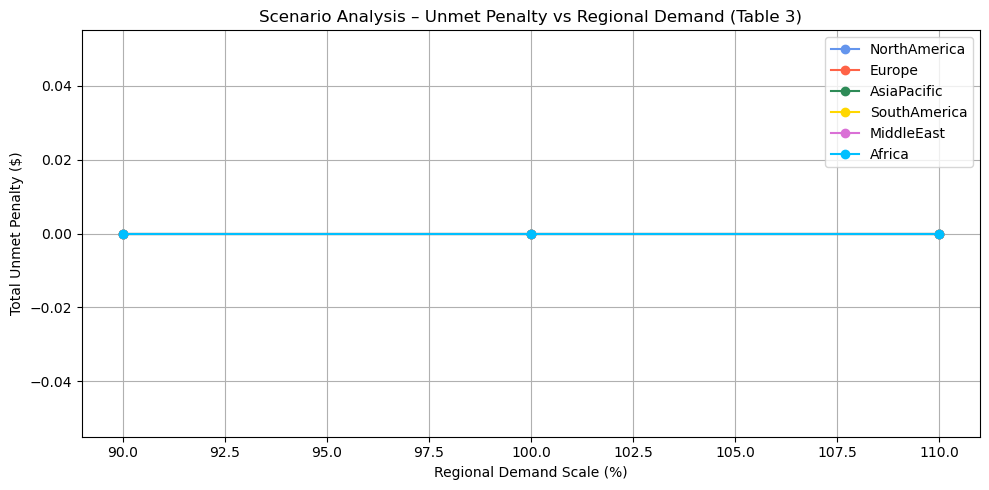

In [24]:
# Convert results to a DataFrame for easy manipulation
df3 = pd.DataFrame(table3_results)

# Define a custom color map for regions
region_colors = {
    'NorthAmerica': 'cornflowerblue',
    'Europe': 'tomato',
    'AsiaPacific': 'seagreen',
    'SouthAmerica': 'gold',
    'MiddleEast': 'orchid',
    'Africa': 'deepskyblue'
}

# Plotting the results for Unmet Penalty vs. Regional Demand Scale
plt.figure(figsize=(10, 5))

# Plot each region's results with a unique line and custom color
for region in df3['Region'].unique():
    subset = df3[df3['Region'] == region]
    color = region_colors.get(region, 'gray')  # Default to gray if region is not in the dictionary
    plt.plot(subset['DemandScale'], subset['PenaltyCost'], marker='o', label=region, color=color)

# Adding title and labels
plt.title("Scenario Analysis – Unmet Penalty vs Regional Demand (Table 3)")
plt.xlabel("Regional Demand Scale (%)")
plt.ylabel("Total Unmet Penalty ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()



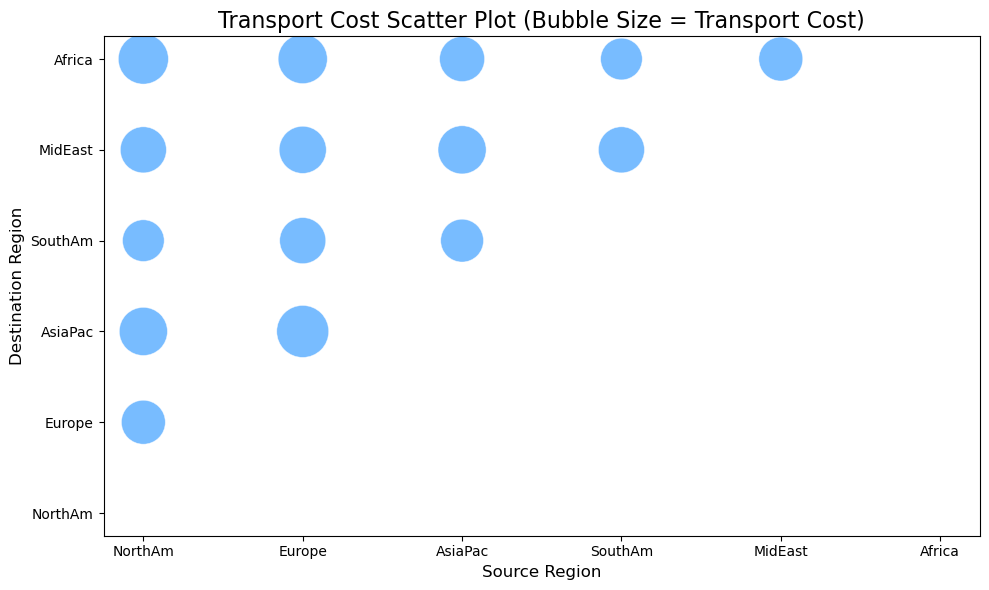

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define regions and initialize the heatmap DataFrame with base_costs directly
regions = ['NorthAm', 'Europe', 'AsiaPac', 'SouthAm', 'MidEast', 'Africa']
heatmap_df = pd.DataFrame(index=regions, columns=regions, data=0)

# Assuming base_costs is a dictionary with region pairs and associated costs
base_costs = {
    ('NorthAm', 'Europe'): 100, 
    ('NorthAm', 'AsiaPac'): 120, 
    ('NorthAm', 'SouthAm'): 90, 
    ('NorthAm', 'MidEast'): 110, 
    ('NorthAm', 'Africa'): 130,
    ('Europe', 'AsiaPac'): 140,
    ('Europe', 'SouthAm'): 110,
    ('Europe', 'MidEast'): 115,
    ('Europe', 'Africa'): 125,
    ('AsiaPac', 'SouthAm'): 95,
    ('AsiaPac', 'MidEast'): 120,
    ('AsiaPac', 'Africa'): 105,
    ('SouthAm', 'MidEast'): 110,
    ('SouthAm', 'Africa'): 90,
    ('MidEast', 'Africa'): 100
}

# Populate the heatmap_df DataFrame directly
for (i, j), cost in base_costs.items():
    heatmap_df.loc[i, j] = cost

# Convert DataFrame to a long format suitable for scatter plot
long_df = heatmap_df.reset_index().melt(id_vars='index', var_name='Destination', value_name='Cost')
long_df.columns = ['Source', 'Destination', 'Cost']

# Plotting the scatter plot with bubble sizes representing the transport costs
plt.figure(figsize=(10, 6))
plt.scatter(
    data=long_df, 
    x='Source', 
    y='Destination', 
    s=long_df['Cost']*10,  # Scaling the bubble size by transport cost
    color='dodgerblue', 
    alpha=0.6, 
    edgecolors="w", 
    linewidth=0.5
)

# Adding labels and titles
plt.title("Transport Cost Scatter Plot (Bubble Size = Transport Cost)", fontsize=16)
plt.xlabel("Source Region", fontsize=12)
plt.ylabel("Destination Region", fontsize=12)
plt.tight_layout()

# Show plot
plt.show()



In [26]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import copy

# Base Data
base_costs = {
    ('NorthAm', 'Europe'): 3, ('NorthAm', 'AsiaPac'): 5, ('NorthAm', 'SouthAm'): 2,
    ('Europe', 'AsiaPac'): 4, ('Europe', 'Africa'): 3, ('Europe', 'MidEast'): 2,
    ('AsiaPac', 'Europe'): 4, ('AsiaPac', 'Africa'): 8, ('AsiaPac', 'NorthAm'): 5, ('AsiaPac', 'SouthAm'): 6,
    ('SouthAm', 'NorthAm'): 2
}

region_supply = {
    'NorthAm': 1320000,
    'Europe': 880000,
    'AsiaPac': 2225000,
    'SouthAm': 1160000
}

region_demand = {
    'NorthAm': 1320000,
    'Europe': 880000,
    'AsiaPac': 575000 + 690000 + 460000,     
    'SouthAm': 220000 + 330000 + 220000,
    'MidEast': 275000 + 440000 + 330000,
    'Africa': 172500 + 230000 + 172500
}


In [27]:
def solve_transport_model(costs, supply, demand):
    model = pulp.LpProblem("Transport_Optimization", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("Ship", costs.keys(), lowBound=0, cat='Integer')
    regions = set(list(supply.keys()) + list(demand.keys()))

    model += pulp.lpSum(x[(i, j)] * costs[(i, j)] for (i, j) in costs)

    for i in supply:
        model += pulp.lpSum(x[(i, j)] for j in regions if (i, j) in x) <= supply[i], f"Supply_{i}"
    for j in demand:
        model += pulp.lpSum(x[(i, j)] for i in regions if (i, j) in x) >= demand[j], f"Demand_{j}"

    model.solve()
    return {
        'status': pulp.LpStatus[model.status],
        'cost': pulp.value(model.objective),
        'plan': {f"{i} ➜ {j}": int(x[(i, j)].varValue)
                 for (i, j) in x if x[(i, j)].varValue and x[(i, j)].varValue > 0}
    }

# Scenario 1: AsiaPacific route cost increase
scenarios = []
for factor in [1.0, 1.1, 1.2]:
    mod = {k: (v * factor if 'AsiaPac' in k else v) for k, v in base_costs.items()}
    res = solve_transport_model(mod, region_supply, region_demand)
    scenarios.append({'Scenario': f'AsiaPac Routes +{int((factor-1)*100)}%', 'Cost': res['cost']})


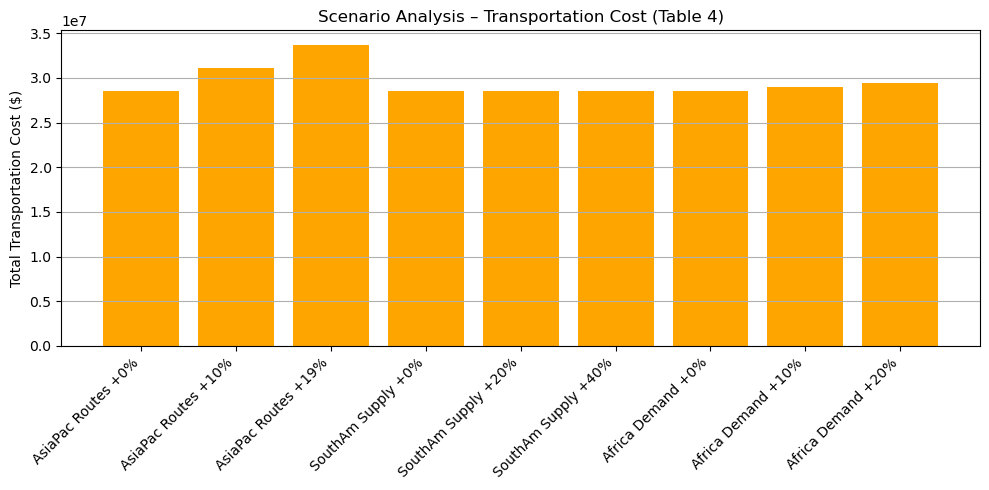

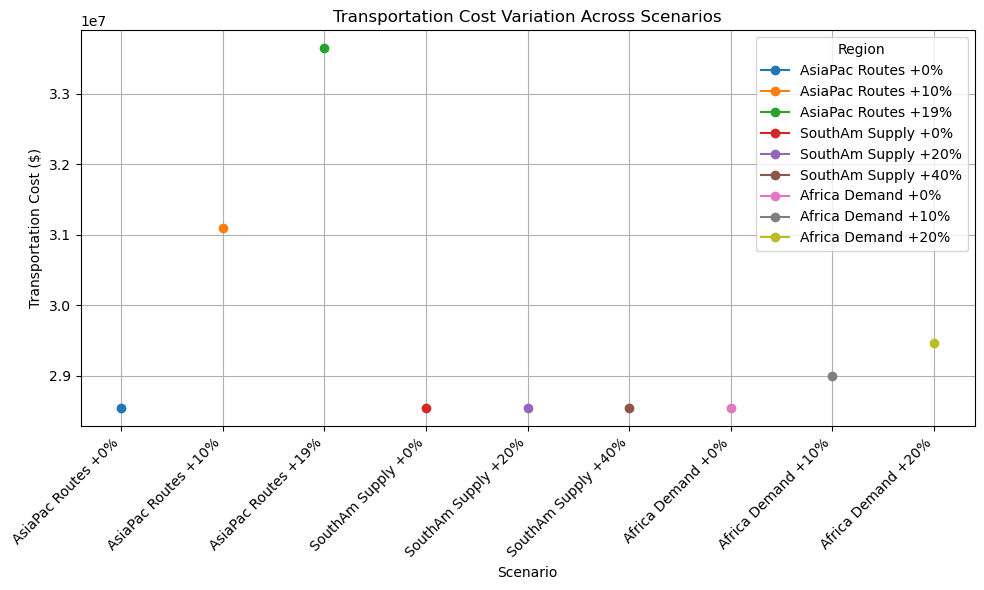

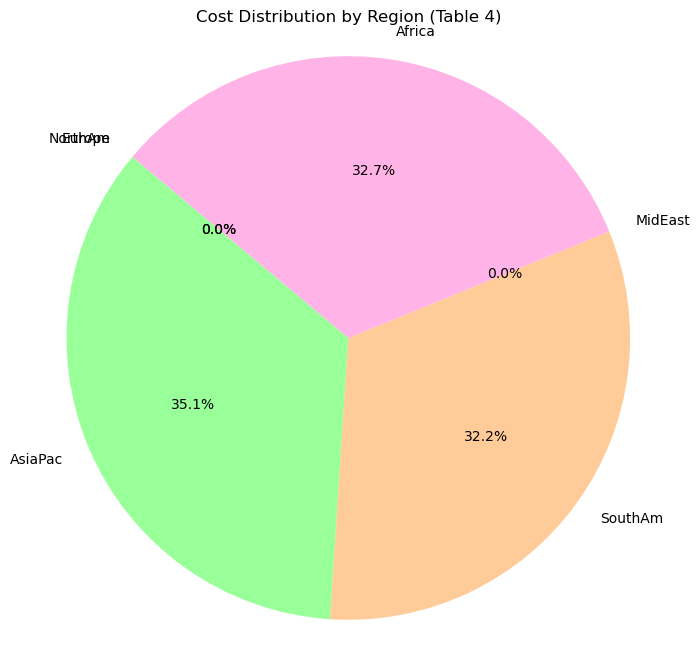

In [28]:
# Scenario 4: SouthAmerica capacity increase
for inc in [0.0, 0.2, 0.4]:
    mod_supply = copy.deepcopy(region_supply)
    mod_supply['SouthAm'] = int(region_supply['SouthAm'] * (1 + inc))
    res = solve_transport_model(base_costs, mod_supply, region_demand)
    scenarios.append({'Scenario': f'SouthAm Supply +{int(inc*100)}%', 'Cost': res['cost']})

# Scenario 5: Africa demand surge
for inc in [0.0, 0.1, 0.2]:
    mod_demand = copy.deepcopy(region_demand)
    mod_demand['Africa'] = int(region_demand['Africa'] * (1 + inc))
    res = solve_transport_model(base_costs, region_supply, mod_demand)
    scenarios.append({'Scenario': f'Africa Demand +{int(inc*100)}%', 'Cost': res['cost']})

# Prepare DataFrame for plotting
df = pd.DataFrame(scenarios)

# Plotting the bar chart (Total Transportation Cost)
plt.figure(figsize=(10, 5))
plt.bar(df['Scenario'], df['Cost'], color='orange')
plt.title("Scenario Analysis – Transportation Cost (Table 4)")
plt.ylabel("Total Transportation Cost ($)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Line plot showing cost variation across scenarios
plt.figure(figsize=(10, 6))
for region in df['Scenario'].unique():
    subset = df[df['Scenario'] == region]
    plt.plot(subset['Scenario'], subset['Cost'], marker='o', label=region)

plt.title("Transportation Cost Variation Across Scenarios")
plt.xlabel("Scenario")
plt.ylabel("Transportation Cost ($)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

# Pie chart showing the distribution of costs by region
# Aggregating cost by region (for visualization)
region_costs = {
    'NorthAm': sum(df[df['Scenario'].str.contains('NorthAm')]['Cost']),
    'Europe': sum(df[df['Scenario'].str.contains('Europe')]['Cost']),
    'AsiaPac': sum(df[df['Scenario'].str.contains('AsiaPac')]['Cost']),
    'SouthAm': sum(df[df['Scenario'].str.contains('SouthAm')]['Cost']),
    'MidEast': sum(df[df['Scenario'].str.contains('MidEast')]['Cost']),
    'Africa': sum(df[df['Scenario'].str.contains('Africa')]['Cost'])
}

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(region_costs.values(), labels=region_costs.keys(), autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6'])
plt.title("Cost Distribution by Region (Table 4)")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


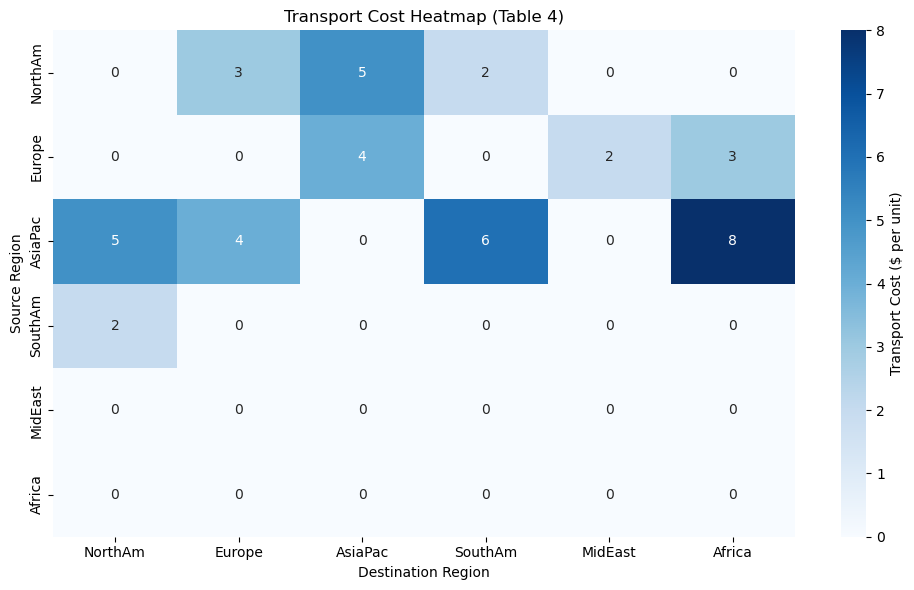

In [29]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Base costs dictionary
base_costs = {
    ('NorthAm', 'Europe'): 3, ('NorthAm', 'AsiaPac'): 5, ('NorthAm', 'SouthAm'): 2,
    ('Europe', 'AsiaPac'): 4, ('Europe', 'Africa'): 3, ('Europe', 'MidEast'): 2,
    ('AsiaPac', 'Europe'): 4, ('AsiaPac', 'Africa'): 8, ('AsiaPac', 'NorthAm'): 5, ('AsiaPac', 'SouthAm'): 6,
    ('SouthAm', 'NorthAm'): 2
}

# Create a DataFrame for the base costs to display in the heatmap
regions = ['NorthAm', 'Europe', 'AsiaPac', 'SouthAm', 'MidEast', 'Africa']
heatmap_df = pd.DataFrame(index=regions, columns=regions, data=0)

# Populate the DataFrame with the base cost values
for (i, j), cost in base_costs.items():
    heatmap_df.loc[i, j] = cost

# Convert the data to numeric format in case there are any string entries
heatmap_df = heatmap_df.apply(pd.to_numeric)

# Plotting the heatmap with blue color scheme
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Transport Cost ($ per unit)'})
plt.title("Transport Cost Heatmap (Table 4)")
plt.xlabel("Destination Region")
plt.ylabel("Source Region")
plt.tight_layout()
plt.show()

